# Biblioteca

In [1]:
# qiskit - para computação quântica
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile # registradores e circuitos quânticos
from qiskit.primitives import StatevectorSampler as Sampler # amostragem de vetores de estado
from qiskit.circuit.library import UnitaryGate # portas unitárias
from qiskit_aer import AerSimulator # type: ignore

# scipy - para manipulação de matrizes
from scipy.linalg import svd # decomposição em valores singulares

# numpy - para manipulação de arrays
import numpy as np 

# random - para geração de números aleatórios
import random 

# Quantum State Preparation - QSP

Funções para Preparação dos Estados

In [2]:
# função para preparar um estado quântico, recebe o circuito, o estado e uma lista com os qubits do circuito
# c - circuito quântico
# s - estado quântico
# q - lista com os qubits do circuito
# n - número de qubits
# k - metade do número de qubits
# U, Vt - matrizes da decomposição em valores singulares
def prepare_state(c, s, q):

    # fase 1 - preparação dos qubits
    n = len(q) # número de qubits

    # se n for 1, inicializa o qubit com o estado
    if n == 1:
        c.initialize(s, q)
        return # se n for maior que 1, continua...

    # divide o estado em duas partes
    k = n // 2 

    # reshape do estado para permitir o uso da função svd
    dim1 = 2 ** k
    dim2 = 2 ** (n - k)
    s = s.reshape((dim1, dim2))

    # decomposição em valores singulares
    U, singular_values, Vt = svd(s)
    singular_values = singular_values / np.linalg.norm(singular_values)

    # chamada recursiva para preparar metade dos qubits
    prepare_state(c, singular_values, q[:k])

    # fase 2 - combinação dos qubits
    for i in range(k):
        c.cx(q[i], q[i + k])

    # fase 3 - gate unitária para a matriz U
    U_gate = UnitaryGate(U, label="U")
    c.append(U_gate, q[:k])

    # fase 4 - gate unitária para a matriz Vt
    Vt_gate = UnitaryGate(Vt.T.conj(), label="Vt")
    c.append(Vt_gate, q[k:])

In [3]:
# função para preparar um estado quântico arbitrário
# n - número de qubits
# s - vetor de amplitudes do estado
# c - circuito quântico
def prepare_arbitrary_state(n, s):
    c = QuantumCircuit(n) # cria um circuito quântico com n qubits

    # chama a função prepare_state para preparar o estado
    prepare_state(c, s, list(range(n)))

    return c # retorna o circuito

Gerador de Amplitude Aleatória

In [4]:
# função para gerar um vetor de estado aleatório
# n - número de qubits
# s - vetor de amplitudes do estado
def gen_random_state(n):
    # gera um vetor de estado aleatório
    s = np.random.rand(2**n) + 1j * np.random.rand(2**n)  
    s = s / np.linalg.norm(s) 

    return s # retorna o vetor de estado

# Quantum Error Correction - QEC

Medição de Estados

In [5]:
# ignora a medição para gerar circuitos maiores
ignore_measuring = False

# função para medir o estado atual
# c - circuito quântico
# n - número de qubits
# m - cópia do circuito original feito para medição
# sp - statevector sampler
# r - resultado da medição
# e - execução do circuito
def measure_current_state(c, n):
    if ignore_measuring:
        return
    
    # cria um circuito de measure que copia o circuito original para testar sem alterar o original
    m = c.copy()

    # registrador classico    
    reg = ClassicalRegister(n, "registrador")
    m.add_register(reg) # adiciona o registrador ao circuito
    
    # mede n qubits 
    for i in range(n):
        m.measure(i, reg[i])

    # executa o circuito
    b = AerSimulator()
    t = transpile(m, b)
    t.save_statevector()
    r = b.run(t).result()
    ct = r.get_counts()
    sv = r.get_statevector() # coleta o resultado da medição
    
    print(ct) # imprime o resultado da medição
    #print(sv) # imprime o vetor de estado
    print("")

Função de Codificação de Shor

In [6]:
# função para codificar um qubit em um estado de 9 qubits como descrito no artigo
# c - circuito quântico
# n - número de qubits
# extra_q - registrador extra
def encode_qubit(c, n):

    # cria um registrador extra
    extra_q = QuantumRegister(8*n, name="extra_q")  
    c.add_register(extra_q) # adiciona o registrador ao circuito
     
    # codifica n qubits em estados de 9 qubits cada
    for i in range(n):

        c.cx(i,8*i + 3 + (n-1))
        c.cx(i,8*i + 6 + (n-1))

        c.h(i)
        c.h(8*i + 3 + (n-1))
        c.h(8*i + 6 + (n-1))

        c.cx(i,8*i + 1 + (n-1))
        c.cx(8*i + 3 + (n-1),8*i + 4 + (n-1))
        c.cx(8*i + 6 + (n-1),8*i + 7 + (n-1))

        c.cx(i,8*i + 2 + (n-1))
        c.cx(8*i + 3 + (n-1),8*i + 5 + (n-1))
        c.cx(8*i + 6 + (n-1),8*i + 8 + (n-1))
        
        c.barrier()

    return c # retorna o circuito após aplicar vários CNOTS e HADAMARDS

Função de Aplicar Erro Aleatório

In [7]:
# função para aplicar um erro aleatório em um dos qubits
# c - circuito quântico
# n - número de qubits
# error_q - qubit que receberá o erro
# error - tipo de erro (x ou z)
def apply_random_error(c, n):
    error_q = random.randint(0, (n*9)-1) # escolhe um qubit aleatório para receber o erro
    error = random.choice(['x', 'z']) # escolhe um erro aleatório (x ou z)
    
    # aplica o erro no qubit escolhido
    if error == 'x':
        c.x(error_q) # aplica a porta X no circuito
    else:
        c.z(error_q) # aplica a porta Z no circuito

    # coloca uma barreira no circuito
    c.barrier()

    # retorna o circuito com o erro aplicado
    return c

Extração de Síndrome

In [8]:
# função para extrair o síndrome de um estado de 9 qubits
# c - circuito quântico
# sp - statevector sampler
# syn_q - síndrome
# syn_c - registrador clássico para o síndrome
# l_syn - lista de síndromes 
def extract_syndrome(c, n):
    sp = Sampler() 

    l_syn = [] # lista de síndromes

    # cria os registradores para o síndrome
    syn_q = QuantumRegister(2*n, name="syn_q") 
    syn_c  = ClassicalRegister(2*n, name="syn")

    # adiciona os registradores ao circuito
    c.add_register(syn_q)
    c.add_register(syn_c)

    for i in range(n):
        # aplica as portas HADAMARD para superposição
        c.h(9*n + 2*i)
        c.h(9*n + 2*i + 1)

        # aplica as portas CNOT para gerar a síndrome##########
        c.cx(9*n + 2*i, i)
        for j in range(5):
            c.cx(9*n + 2*i, (n-1) + i*8 + j + 1)
        c.barrier()
        
        c.cx(9*n + 2*i + 1, (n-1) + i*8 + 3)
        for j in range(5):
            c.cx(9*n + 2*i + 1, (n-1) + i*8 + 4 + j)
        c.barrier()
        #######################################################
        
        # aplica as portas HADAMARD para remover superposição
        c.h(9*n + 2*i)
        c.h(9*n + 2*i + 1)

        c.barrier()

        # cópia para medir, pois não é possível medir no meio do circuito com qiskit
        copy = c.copy()
        copy.measure(9*n + 2*i, 2*i)
        copy.measure(9*n + 2*i + 1, 2*i + 1)

        e = sp.run([copy])
        r = e.result()
        syn = r[0].data.syn.get_counts()
        l_syn.append(syn)

    # retorna o circuito e as listas de síndromes
    return l_syn

Corrigir Erros

In [9]:
# função para corrigir um erro em um estado de 9 qubits
# c - circuito quântico
# n - número de qubits
# syn - síndrome
# ZERO - estado de Y bits com todos os qubits em 0
# Z - estado de 2 bits com posição do erro no bloco
# bits_duplos - lista de bits duplos
# z - bit duplo 
# b - bloco
def correct_error(c, n, syn):

    # manipulação de string #######################
    lista = syn
    n = len(lista)
    ZERO = '0' * (n * 2)
    Z = None

    for dicionario in lista:
        chave = list(dicionario.keys())[0]  
        if chave != ZERO:
            Z = chave
            break

    if Z == None:
        return
    ##############################################

    bits_duplos = []

    # separa os bits duplos
    for i in range(0, len(Z), 2):
        bit_duplo = Z[i:i+2]  
        posicao = i // 2      
        if bit_duplo != '00':
            bits_duplos.append((bit_duplo, posicao)) 

    z = bits_duplos[0][0]
    b = bits_duplos[0][1]

    # corrige bloco dependendo do numero de qubits
    b = (b - (n-1))*-1

    # aplica a correção de erro no circuito
    if z == '01':
        c.z(b)
    elif z == '11':
        c.z((n+2) + b*9)
    elif z == '10':
        c.z((n+5) + b*9)
    
    c.barrier()


Função de Decodificação de Shor

In [10]:
# função para decodificar um qubit de 9 qubits
# c - circuito quântico
# n - número de qubits
def decode_qubit(c, n):

    for i in range(n): 
        c.cx(i, i*8 + n) 
        
        c.cx(i*8 + n + 2, i*8 + n + 3) 
        c.cx(i*8 + n + 5, i*8 + n + 6) 

        c.cx(i, i*8 + n + 1)

        c.cx(i*8 + n + 2, i*8 + n + 4) 
        c.cx(i*8 + n + 5, i*8 + n + 7) 

        c.ccx(i*8 + n, i*8 + n + 1, i) 
        c.ccx(i*8 + n + 4, i*8 + n + 3, i*8 + n + 2) 
        c.ccx(i*8 + n + 7, i*8 + n + 6, i*8 + n + 5) 

        c.h(i) 
        c.h(i*8 + n + 2)
        c.h(i*8 + n + 5)

        c.cx(i, i*8 + n + 2) 
        c.cx(i, i*8 + n + 5) 
        c.ccx(i*8 + n + 5, i*8 + n + 2, i) 

        c.barrier()
    
    return c

# Controlador do Corretor de Erros Quântico

In [11]:
# função de controle
# c - circuito quântico
# n - número de qubits
def qec(c, n):

    print("Estados iniciais:")
    measure_current_state(c, n)
        
    ###########################################
    #''' código de Shor
    encode_qubit(c, n)

    print("Estados pós codificação de Shor:")
    measure_current_state(c, n*9)

    #'''

    ###########################################
    #''' aplicar erro
    apply_random_error(c, n)

    print("Estados pós aplicação de erro:")
    measure_current_state(c, n*9)

    #'''

    ###########################################
    #''' extração da síndrome
    syn = extract_syndrome(c, n)

    print("Síndrome:")
    print(syn)
    print("")

    #'''

    ###########################################
    #''' correção do erro Z
    correct_error(c, n, syn)

    print("Estados pós correção de erro Z:")
    measure_current_state(c, n*9)

    #'''

    ###########################################
    #''' decodificação (correção de erro X)
    decode_qubit(c, n)
    
    print("Estados pós decode:")
    measure_current_state(c, n)

    #'''

    ###########################################    

    return c

# Aplicações

Aplicação QSP

{'0011': 98, '1100': 91, '1011': 91, '0010': 67, '1110': 50, '0101': 124, '1010': 37, '1000': 54, '0100': 42, '0000': 112, '0110': 44, '1001': 48, '0001': 84, '1111': 52, '0111': 23, '1101': 7}



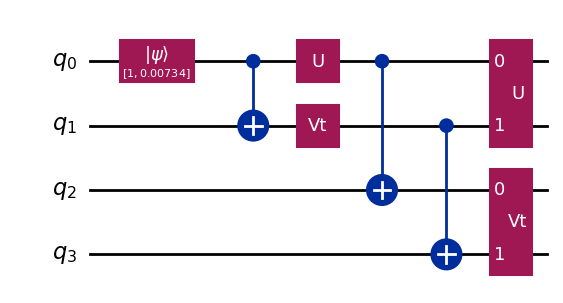

In [12]:
n = int(input('Insira o número de qubits que quer preparar: ')) # número de qubits

# prepara o circuito quântico com o estado e o número de qubits especificados
c = prepare_arbitrary_state(n, gen_random_state(n))

# mede o estado atual
measure_current_state(c, n)

# desenha o circuito
c.draw('mpl')

Aplicação QEC

In [ ]:
# variável para ignorar a medição ou não (True para ignorar)
ignore_measuring = False
# variável para verificar se o circuito inicia em 0
c_zero = False 

# dificuldade para gerar com qualquer quantidade maior que 1 qubit
n = 2 # int(input('Insira o número de qubits que quer preparar: '))  # selecionar o número de qubits

# prepara o estado aleatório com n qubits
if c_zero:
    c = prepare_arbitrary_state(n, np.array([1, 0]))
else:
    c = prepare_arbitrary_state(n, gen_random_state(n))

qec(c, n) # executa o código de correção de erro

# desenhar circuito
c.draw('mpl')

Estados iniciais:
{'00': 544, '01': 347, '10': 132, '11': 1}

Estados pós codificação de Shor:
{'000111111111111111': 6, '111000111111111111': 5, '111111000000000000': 40, '000000001111110000': 42, '000111110001111111': 43, '111000000000000000': 13, '111000111110001111': 47, '111000110001111111': 51, '000000000001111101': 52, '111000000001111101': 10, '000111110000001111': 4, '111111001110001101': 49, '111111001110000000': 4, '000111110000000010': 42, '000111001111111101': 1, '000000111111110010': 15, '000000111110001111': 17, '000111001110000000': 1, '000111111110000010': 3, '000000001110001101': 39, '111111110000000010': 17, '111000111110000010': 4, '111000110001110010': 4, '111111000001111101': 42, '111000001111110000': 11, '000000000000001101': 6, '111111001111110000': 41, '111111001111111101': 3, '000000000000000000': 55, '111111000000001101': 5, '111000111111110010': 45, '000000001111111101': 6, '000111111111110010': 53, '000111001111110000': 11, '000000001110000000': 2, '0001111

Aplicação da Porta X

{'0': 1015, '1': 9}

{'0': 1009, '1': 15}



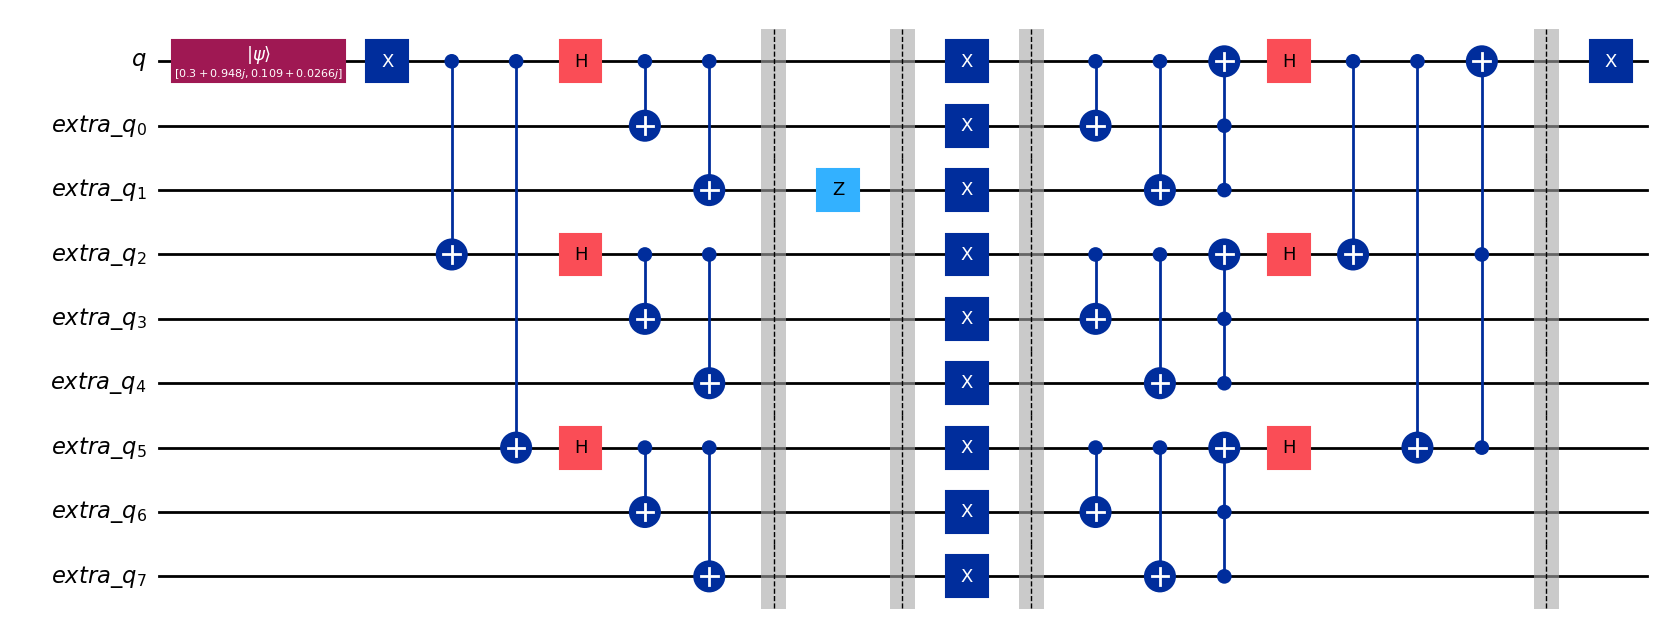

In [17]:
# porta x de modo transversal

a = 1
b = prepare_arbitrary_state(a, gen_random_state(n))
measure_current_state(b, a)
b.x(0)
encode_qubit(b, a)

apply_random_error(b, a)

for i in range(9):
    b.x(i)
b.barrier()

decode_qubit(b, a)
b.x(0)
measure_current_state(b, a)
b.draw('mpl')